# Analyze the tree-guided MTL results on the iPCs data produced by Kathrin (data imputed)

The purpose of this analysis is to study the role of transcription factors (TFs) in deriving the gene expession in single cells of two annotated cell types: HLC and PHH. We expect the statistical model to select distinct sets of TFs for each cell type.

## Data
The data to be used for training the tree-guided MTL model:

### Features
Promoter: The binding affinity of ~700 TFs are estimated in a 2kb window around the TSSof each gene.

### Responses
   * The response **matrix** here is essentially the gene expression matrix for the iPCs cells.
   * scImpute was run on the entire gene expression with the k parameter (indicating the num of cell types) to 2 to address the drop-out issue.

## Filtering
### Based on gene expression variance
The genes showing small variance in their expression across the single cells are removed from the data.
### Based on TF expression
The TFs that their corresponding genes are not expressed in more than 90% of the cells are removed as well.

## Model fitting
* Partitioned 60% of the data for training and 40% for test
* Data is normalized with zero mean and unit variance
* 5-fold CV is used to select the model with best average CV error.
* 21 lambda values are explored during the CV prodecure.
* Maximum number of iterations is limitted to 200

The fitted model together with the partitioned data are stored in an RData object that can be loaded.

## Load the model trained on imputed data

In [1]:
load("../scMTL_StemNet_imputed_TPM_TGGLasso_hc_real_weights_corrected_max_iter_200.RData")

## Log-transfer and normalize the partitioned data
The stored partitioned data in the above RData object is in the original space. In order to proceed with the downstream analysis, it's easier to normalize them in the same way they were done before model fitting.

In [2]:
x.train <- scale(log2(1 + partition$train$x))
y.train <- scale(log2(1 + partition$train$y))


x.test <- scale(log2(1 + partition$test$x), center= colMeans(log2(1 + partition$train$x)),
                scale= apply(log2(1 + partition$train$x), 2, FUN= sd))
y.test <- scale(log2(1 + partition$test$y), center= colMeans(log2(1 + partition$train$y)),
                scale= apply(log2(1 + partition$train$y), 2, FUN= sd))

## Train and test dimenstion

In [3]:
print("train:")
print(dim(x.train))
print("test:")
print(dim(x.test))

[1] "train:"
[1] 8343  464
[1] "test:"
[1] 5563  464


## Cell names

In [4]:
head(colnames(y.train))

[1] "HLC_CEL_c1_R1"  "HLC_CEL_c10_R1" "HLC_CEL_c11_R1" "HLC_CEL_c13_R1"
[5] "HLC_CEL_c14_R1" "HLC_CEL_c15_R1"

## PCA applied on training and test features
Unfortunately this part does not work for this dataset, since we have more features than samples (more TFs than genes)

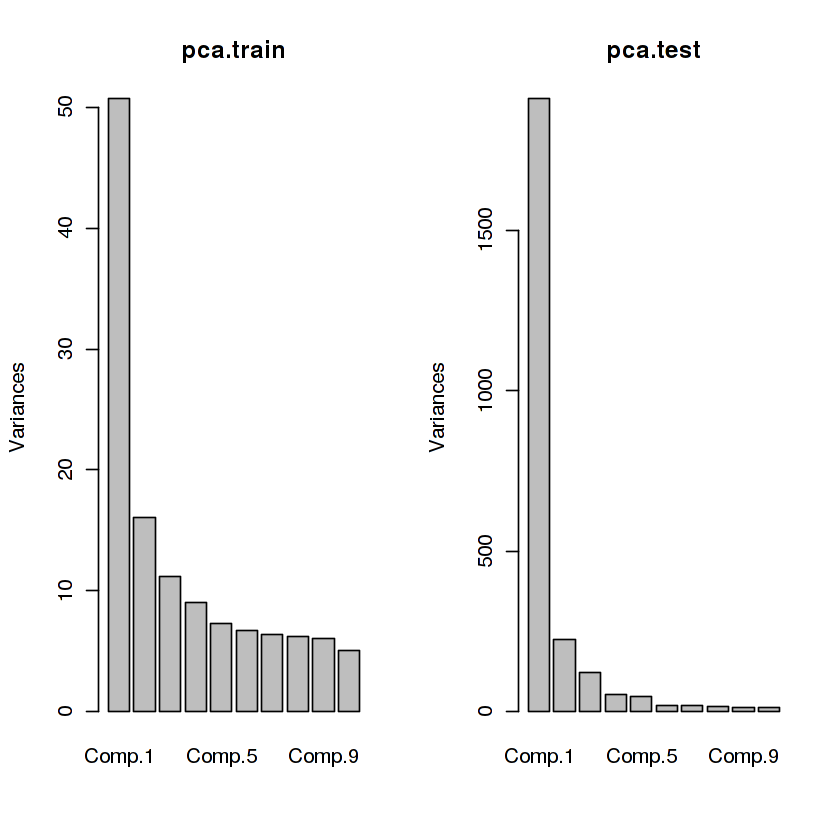

In [5]:
doPCA <- TRUE
if(doPCA){
    pca.train <- princomp(x.train)
    pca.test <- princomp(x.test)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Compute the predictions on training and test data

In [6]:
pred.train <- cbind(1, x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
pred.test <- cbind(1, x.test) %*% rbind(TGL.model$intercept, TGL.model$B)

### Plot the scatter plots for some random cells (training data)

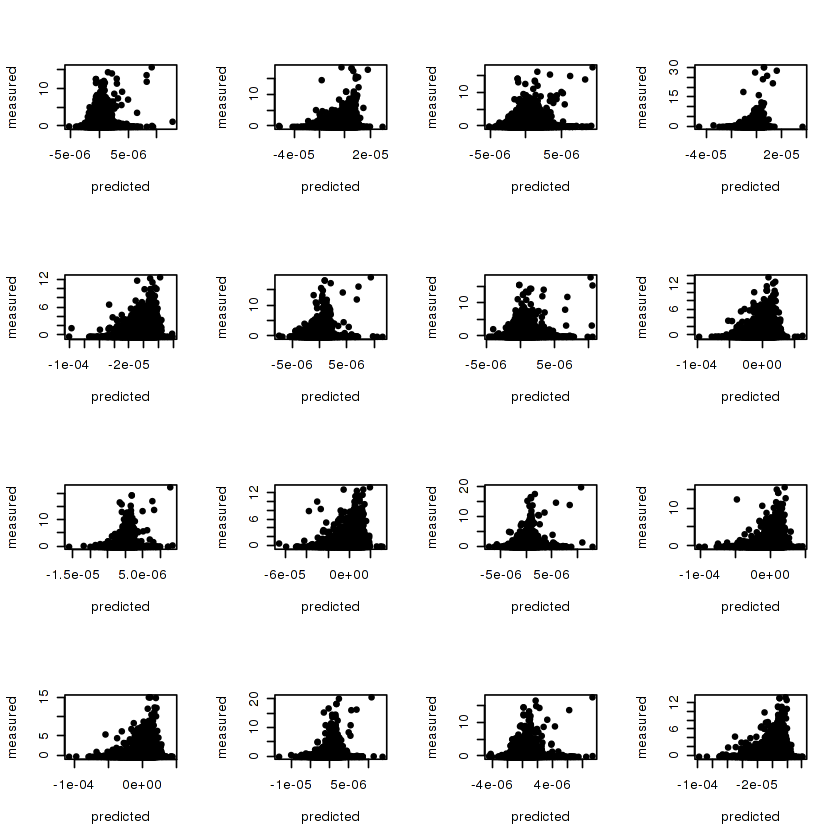

In [7]:
n <- 16
par(mfrow = c(sqrt(n), sqrt(n)))

random.idx <- sample(ncol(pred.train))[seq(n)]
for(i in seq(n))
    plot(pred.train[, random.idx[i]], y.train[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

### Plot the scatter plots for some random cells (test data)

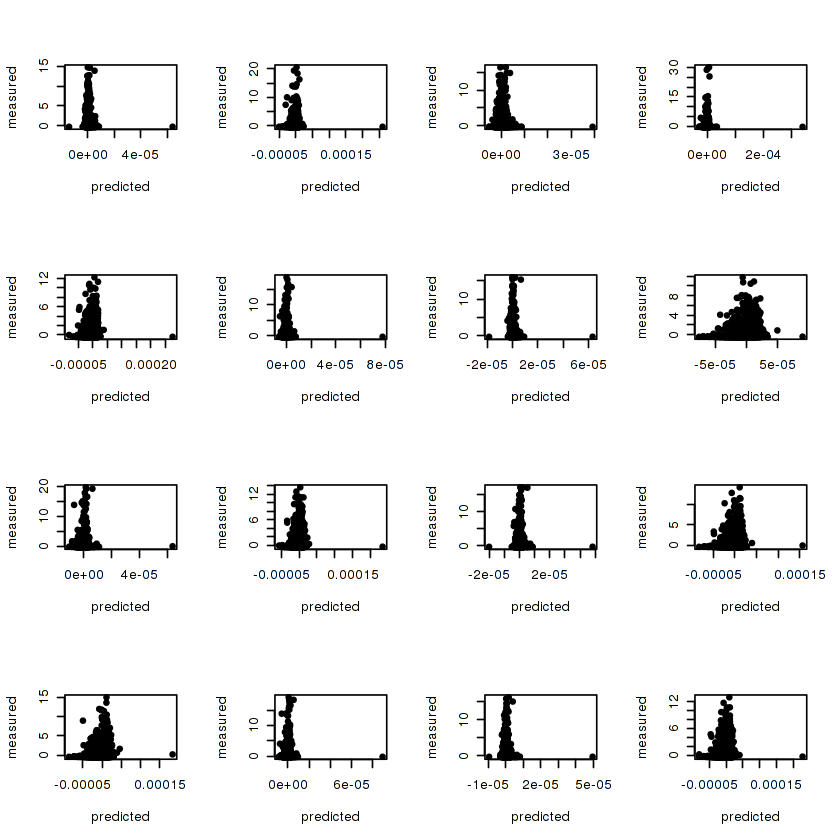

In [8]:
#n <- 25
par(mfrow = c(sqrt(n), sqrt(n)))

#random.idx <- sample(ncol(pred.test))[seq(n)]
for(i in seq(n))
    plot(pred.test[, random.idx[i]], y.test[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

## Compute the correlations between predicted and actual measurements of gene expression

In [9]:
# Train
## Method= Pearson
cors.train.p <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "pearson"))

## Method= Spearman
cors.train.s <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "spearman"))
                      
# Test
## Method= Pearson
cors.test.p <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "pearson"))

## Method= Spearman
cors.test.s <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "spearman"))

Warning message in cor(pred.train[, i], y.train[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "spearman"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "spearman"):
“the standard deviation is zero”Warning message in cor(pred.train[, i], y.train[, i], method = "spearman"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y.test[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y.test[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y.test[, i], method = "pearson"):
“the standard deviation is zero”Warning message in cor(pred.test[, i], y

## Plot the prediction correlations for each cell colored according to the cell type

In [10]:
cell.types <- sapply(seq(ncol(y.train)), function(i) strsplit(colnames(y.train)[i], "_")[[1]][1])
print(range(cell.types))

[1] "HLC" "PHH"


### HLC: red, PHH: blue

In [11]:
cols <- rep("red", ncol(y.train))
cols[which(cell.types == "PHH")] <- "blue"

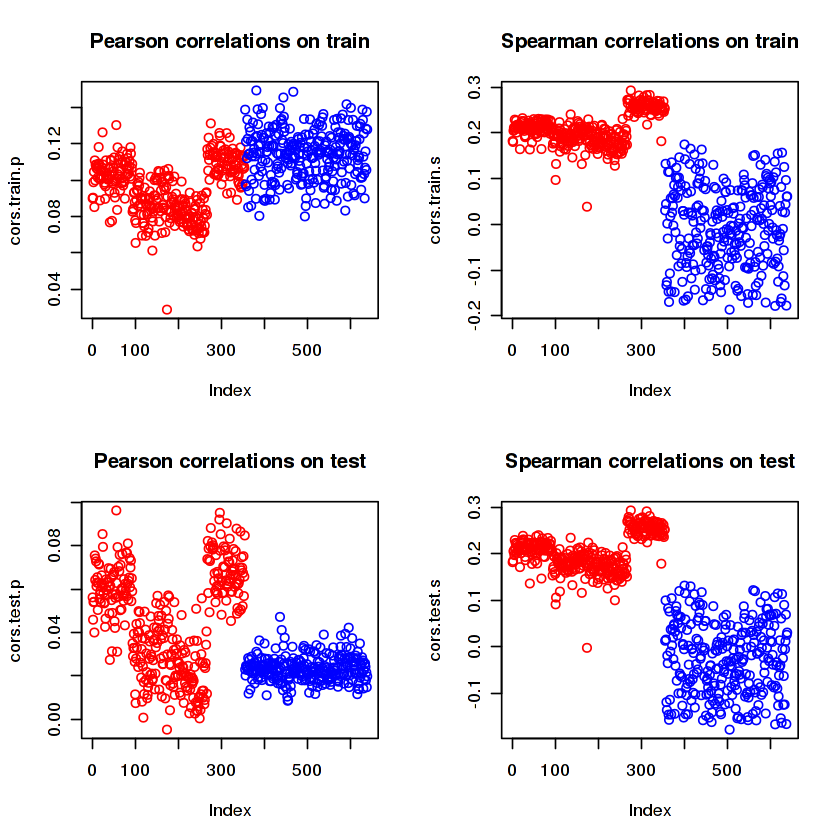

In [12]:
par(mfrow = c(2, 2))

plot(cors.train.p, main= "Pearson correlations on train", col= cols)
plot(cors.train.s, main= "Spearman correlations on train", col= cols)
plot(cors.test.p, main= "Pearson correlations on test", col= cols)
plot(cors.test.s, main= "Spearman correlations on test", col= cols)

## Plot the coefficients obtained from the model

In [17]:
## Load the heatmap library
library(pheatmap)

## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)

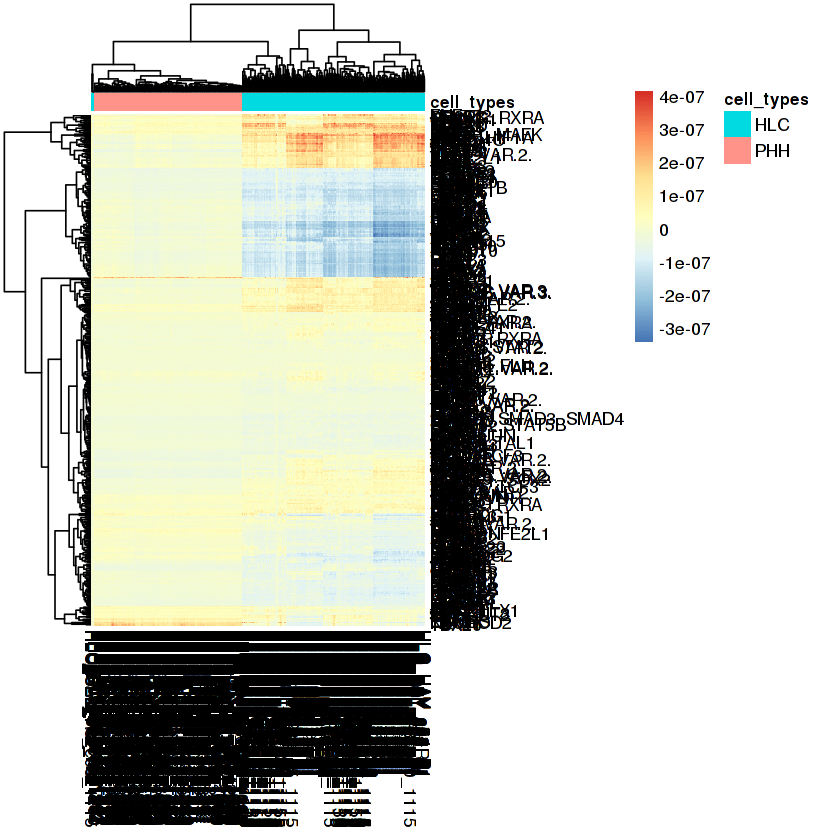

In [14]:
pheatmap(TGL.model$B, annotation_col= ann_col)

As there are quite a lot of the small-valued coefficients in the heatmap, it makes sense to plot only the few with higher values.

In [19]:
print(range(rowSums(abs(TGL.model$B))))
top_TFs <- which(rowSums(abs(TGL.model$B)) > .05)
length(top_TFs)

[1] 3.103898e-06 9.144090e-05


[1] 0

In [16]:
pheatmap(TGL.model$B[top_TFs, ], annotation_col= ann_col)

ERROR: Error in hclust(d, method = method): must have n >= 2 objects to cluster


### Printing top TFs

In [ ]:
print(rownames(TGL.model$B[top_TFs, ]))

There is a clear distiction in the coefficients of the TFs assigned for each cell type. If the model's performance was better, one could've considered this as a very exciting results with some biological significance. But, as long as the performance is so low (on test), I'll refrain to draw any strong conclusoins on the shown results. This for sure requires further improvements...

## Future work
* Look at the results where only the promoter features are used (UPDATE: The results can now be found below)
* Impute the expression data to see if that helps the prediction

# Conclusion
* The over-fitting was most likely due to the small sample size, especially that I've set the partitioning ratio to 60% to 40%. Maybe increasing that to 80% for training would've helped addressing the over-fitting in the Promoter_Roadmap setup. But, as we discussed the other time, we decided to forget about those Roadmap features due to their cell type specificity in calling the open chromatin regions and the fact that we don't have that information in our data makes the usage of that type of features less relevant.
* There are certain distinct TFs that seem to separate the two cell types. But, having the model predicting the PHH cells so poorly, makes this distinction suspicious to me.